In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
import os
import re
import random
from keras.models import model_from_json, load_model
from keras import optimizers
from keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix
import sys

Using TensorFlow backend.


In [4]:
TEST_FILES_DIR = './test_files/'
CSV_PATH = './small_train_labels.csv'
JSON_MODEL_PATH = './model.json'
WEIGHTS_PATH = './model.h5'
WHOLE_MODEL_PATH = './long-frame-whole-model.h5'

In [5]:
csv_file = pd.read_csv(CSV_PATH)
all_genres = csv_file['genre'].unique()
genre_to_index = {genre: index for index, genre in enumerate(all_genres)}
index_to_genre = {index: genre for index, genre in enumerate(all_genres)}

In [6]:
def get_real_label(file):
  file_numbers = re.sub('([a-z])|(\.)', '', file)
  file_as_int = int(file_numbers)
  return csv_file[csv_file['track_id'] == file_as_int]['genre'].values[0]

def get_predicted_label(file):
  raw_image = Image.open(TEST_FILES_DIR + file)
  resized_image = raw_image.resize((1000, 1000))
  sample_tensor = np.array([np.asarray(resized_image)], np.float32)
  sample_tensor /= 255
  prediction_proba = model.predict(sample_tensor)
  max_index = np.argmax(prediction_proba)
  return index_to_genre[max_index]


In [7]:
model = load_model(WHOLE_MODEL_PATH)

model.summary()

W0717 03:27:26.680213 139836824286976 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 03:27:26.700275 139836824286976 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0717 03:27:26.720498 139836824286976 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0717 03:27:26.739304 139836824286976 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 03:27:26.740544 139836824286976 deprecation_wrap

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1000, 1000, 2)     16002     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 200, 200, 2)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 200, 200, 4)       8004      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 40, 40, 4)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 40, 4)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               819328    
__________

In [5]:
json_architecture = open(JSON_MODEL_PATH)
model = model_from_json(json_architecture.read())
model.load_weights(WEIGHTS_PATH)

W0716 22:28:50.721042 139644374677248 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 22:28:50.741124 139644374677248 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0716 22:28:50.760205 139644374677248 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0716 22:28:50.779187 139644374677248 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 22:28:50.780057 139644374677248 deprecation_wrap

In [8]:
real_labels = []
predicted_labels = []

for file in os.listdir(TEST_FILES_DIR):
    real_labels.append(get_real_label(file))
    predicted_labels.append(get_predicted_label(file))

In [9]:
confusion = confusion_matrix(real_labels, predicted_labels, all_genres)
print('confusion: {}'.format(confusion))

confusion: [[117   1  20  11   1  34  15   1]
 [ 48   0  38   1  26  74  13   0]
 [ 33   0 124  10   1  26   2   4]
 [ 27   4  61  22  17  47   8  14]
 [ 38   0  28   4  52  52  25   1]
 [ 76   2  27  10   1  67  17   0]
 [ 75   1  37   8   2  44  32   1]
 [ 31   1  81  27   1  24  11  24]]


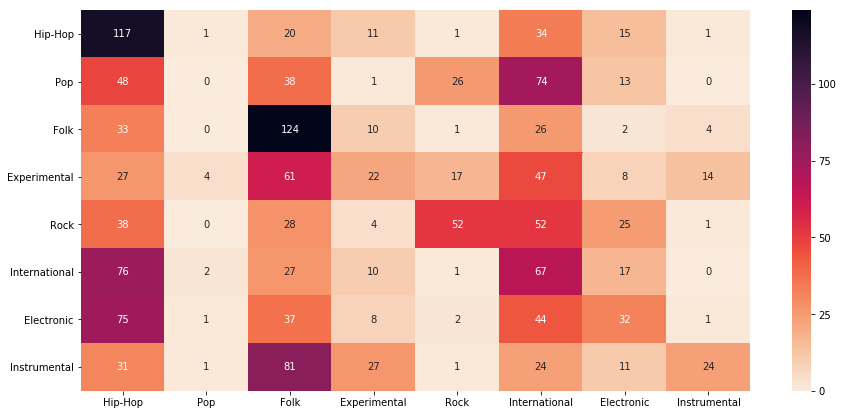

In [11]:
import seaborn
import matplotlib.pyplot as plt

cmap = seaborn.cm.rocket_r

plt.figure(figsize=(15, 7))
heatmap_all = seaborn.heatmap(
    confusion, 
    cmap=cmap, 
    yticklabels=all_genres, 
    xticklabels=all_genres,
    annot=True,
    fmt='g'
)